# Minimierung der Lateness jedes Produktionsauftrags

$$
L_j = C_j - d_j
$$


- $L_j$: Lateness (Verspätung oder Frühfertigung) des Jobs $j$  
- $C_j$: tatsächliche Fertigstellungszeit (Completion Time) von Job $j$  
- $d_j$: Deadline bzw. geplanter Fertigstellungstermin von Job $j$

**Interpretation:**

- $L_j > 0$: Job ist **verspätet**  
- $L_j = 0$: Job ist **pünktlich**  
- $L_j < 0$: Job ist **zu früh** fertig

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
from src.utils.rolling_process.rolling_filter import *
import src.utils.visualization.gantt_diagram as gantt
from src.utils.analysis_basics import check_constrains as check


# Solver Model
from src.models.cp import final_solvers as solver

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)
pd.set_option('display.max_colwidth', 120)

In [2]:
import src.utils.analize.sequence_tester as seq_tester

In [3]:
# Harte Abbruchbedingung für die Scheduler
max_time = 360

# Simulation
simulation = ProductionSimulation(sigma = 0.15)

## I. Laden des fertigen Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [4]:
basic_data_path = get_path("data", "basic")
df_jssp = pd.read_csv(basic_data_path / "jssp_final.csv")
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
72494,J25-7249,4,4,M03,26
72495,J25-7249,4,5,M04,69
72496,J25-7249,4,6,M08,21


In [5]:
df_jobs_times = pd.read_csv(basic_data_path / "jobs_times_final.csv")
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
...,...,...,...,...,...,...,...
7244,J25-7244,3,518085,518400,520251.0,655,520389
7245,J25-7245,9,518089,518400,520296.0,540,519640
7246,J25-7246,6,518116,518400,520027.0,416,520157


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [6]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(
    df_jobs_times, df_previous_not_started = None, ready_time=day_start
)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
1,J25-0001,6,129,1440,2336.0,416,2338
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
7,J25-0007,5,925,1440,2930.0,496,2929
8,J25-0008,4,988,1440,2986.0,393,3541
9,J25-0009,7,1004,1440,3045.0,539,3578


In [8]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_times_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
154,J25-0015,5,4,M08,48
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47


In [9]:
df_jssp_current["Processing Time"].max()

np.int64(99)

### Scheduling

Es liegt kein ursprünglicher Schedule vor!

Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.04 Sekunden
Deviation terms       : 0


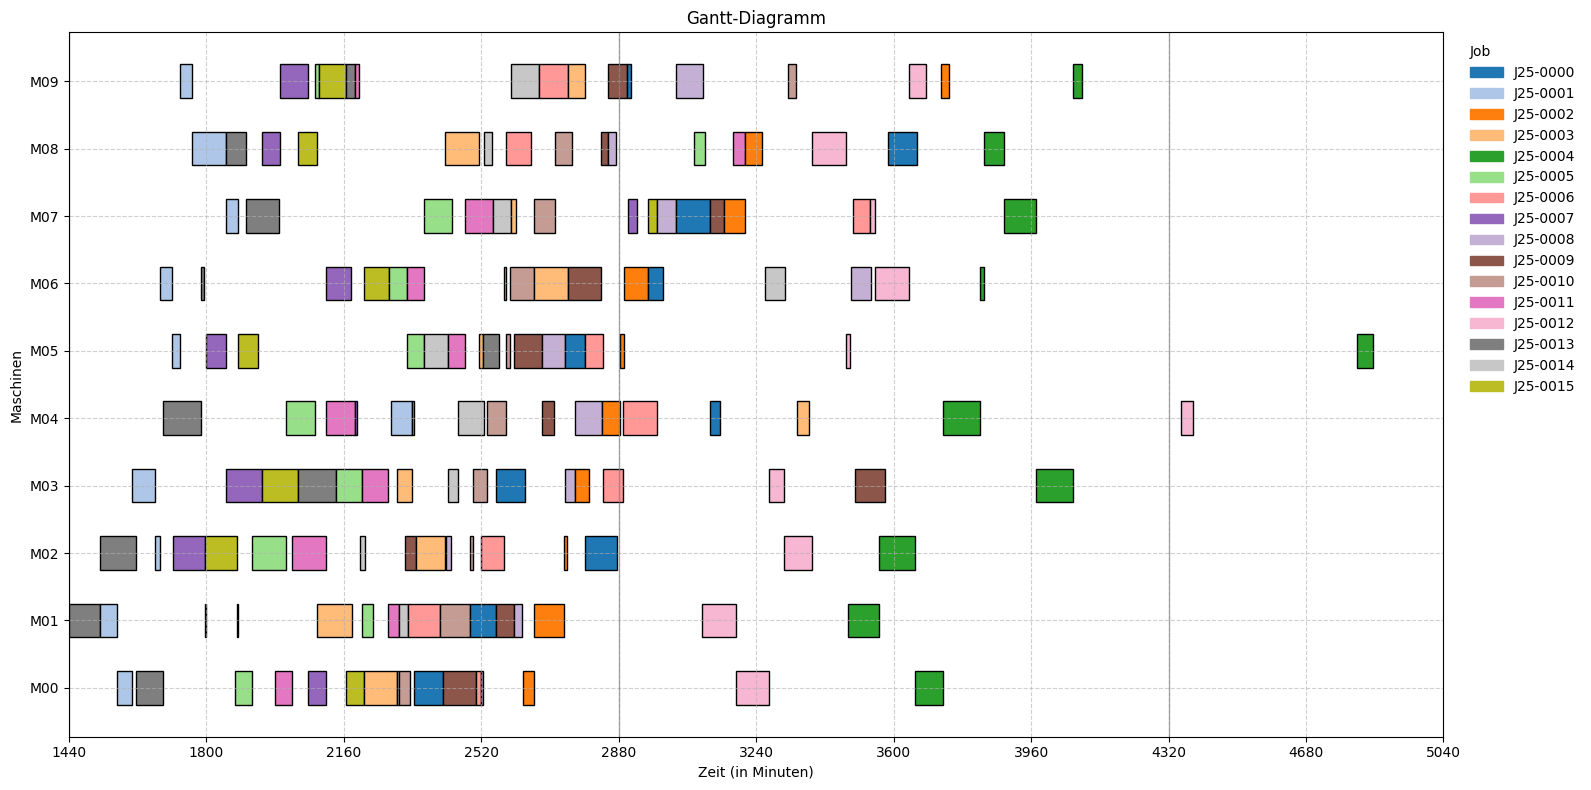

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



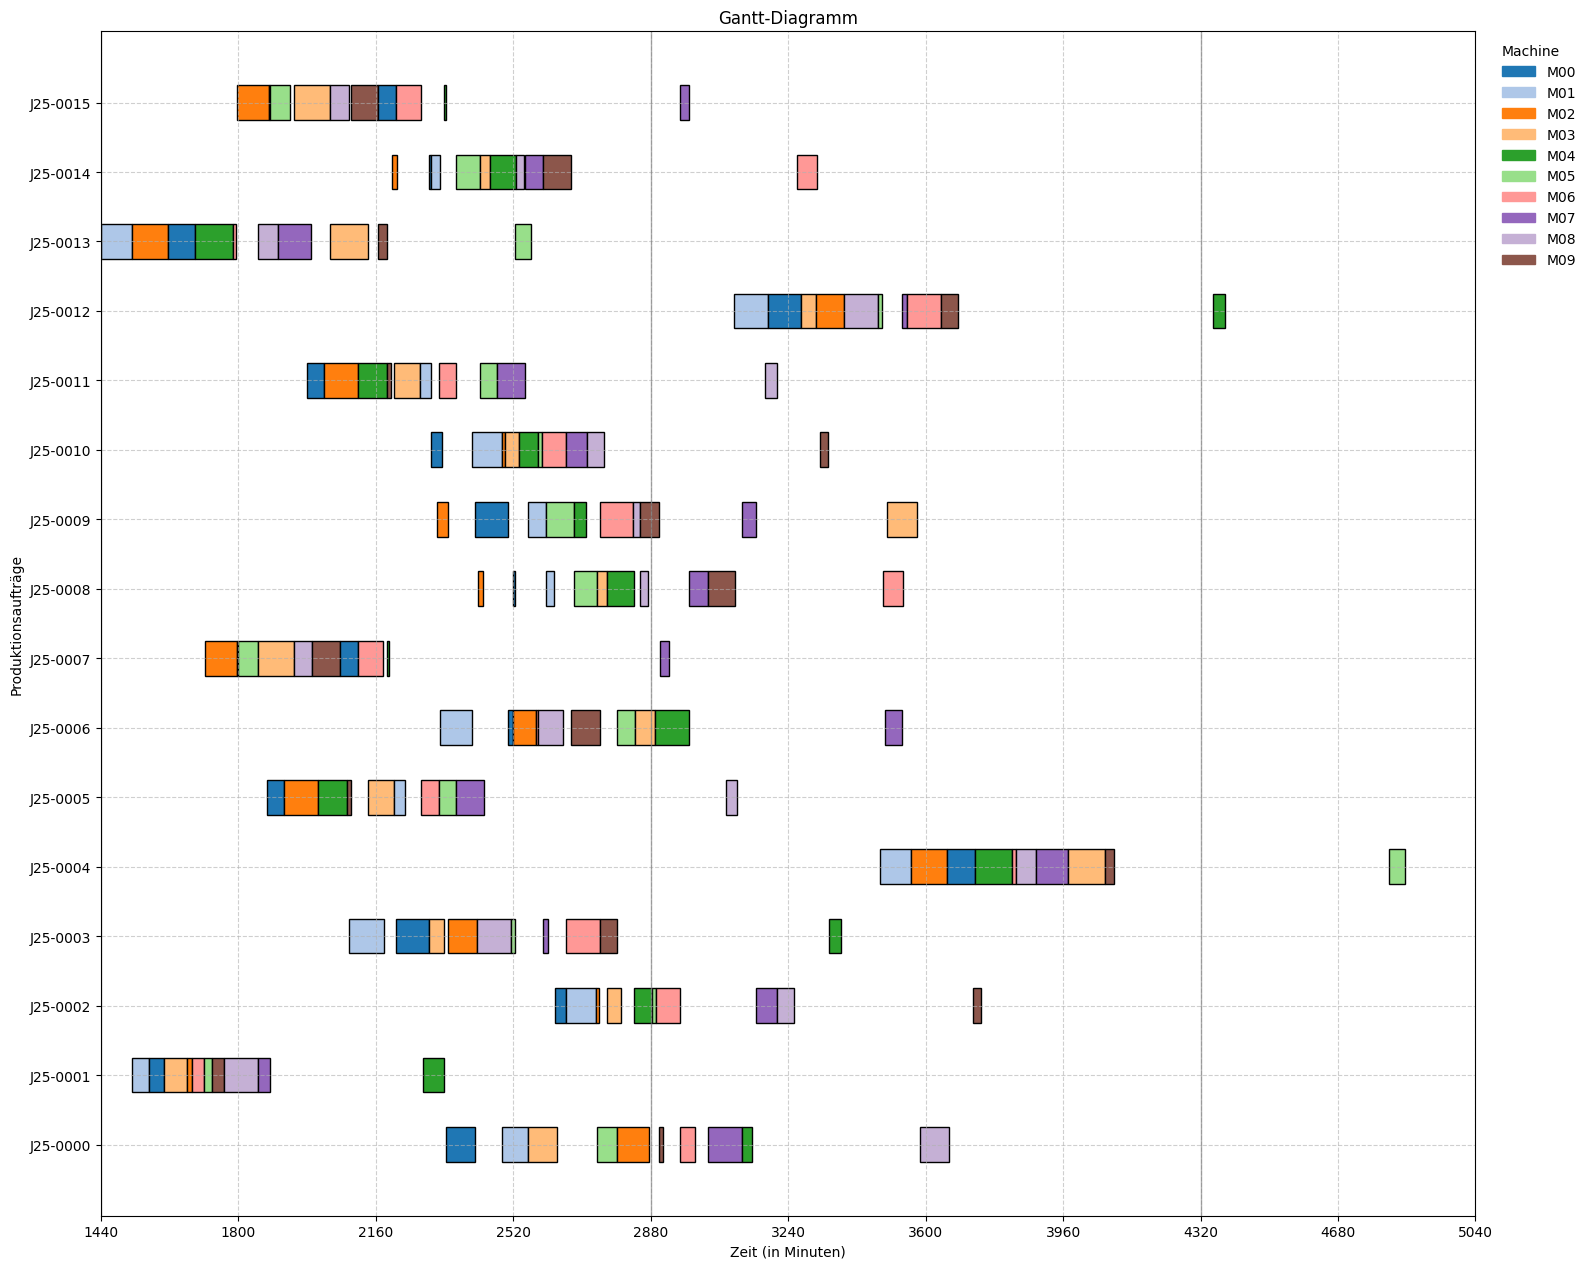

In [10]:
# Scheduling
# earliest_start_column = "Ready Time"

df_schedule = solver.solve_jssp_lateness_with_start_deviation(
    df_jssp=df_jssp_current,
    df_times=df_jobs_times_current,
    df_original_plan=None,
    df_active=None,
    w_t=15, w_e=5, w_first=1,
    main_pct=0.40,               # 40 % "Lateness mit maximierter Startzeit"; 60 % Abweichungen
    latest_start_buffer=720,
    schedule_start=day_start,
    sort_ascending= None,
    msg=True, timeLimit=max_time, gapRel=0.05
)

gantt.get_plot(df_schedule, perspective="Machine")
check.all_in_one(df_schedule)

gantt.get_plot(df_schedule, perspective="Job")

In [11]:
from src.utils.analysis_basics.check_scheduled_jobs import get_jobs_with_lateness_metrics, get_jobs_aggregated

df_last_ops = get_jobs_with_lateness_metrics(df_schedule)
get_jobs_aggregated(df_last_ops, column="Lateness")

Lateness_Intervall,<-120,-120 - -60,-60 - 0,0,0 - 60,60 - 120,>120
count,0,0,0,16,0,0,0


### Simulation

In [12]:
simulation.run(dframe_schedule_plan = df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0013 started on M01
[Day 1 01:16:00] Job J25-0013 finished on M01 (after 76 minutes)
[Day 1 01:21:00] Job J25-0001 started on M01
[Day 1 01:21:00] Job J25-0013 started on M02
[Day 1 02:01:00] Job J25-0001 finished on M01 (after 40 minutes)
[Day 1 02:07:00] Job J25-0001 started on M00
[Day 1 03:01:00] Job J25-0001 finished on M00 (after 54 minutes)
[Day 1 03:01:00] Job J25-0001 started on M03
[Day 1 03:21:00] Job J25-0013 finished on M02 (after 120 minutes)
[Day 1 03:21:00] Job J25-0013 started on M00
[Day 1 04:10:00] Job J25-0001 finished on M03 (after 69 minutes)
[Day 1 04:10:00] Job J25-0001 started on M02
[Day 1 04:23:00] Job J25-0001 finished on M02 (after 13 minutes)
[Day 1 04:23:00] Job J25-0001 started on M06
[Day 1 04:29:00] Job J25-0013 finished on M00 (after 68 minutes)
[Day 1 04:29:00] Job J25-0013 started on M04
[Day 1 04:33:00] Job J25-0007 started on M02
[Day 1 05:00:00] Job J25-0001 finished on M06 (after 37 minutes)
[Day 1 05:00:00] Job J25-0001

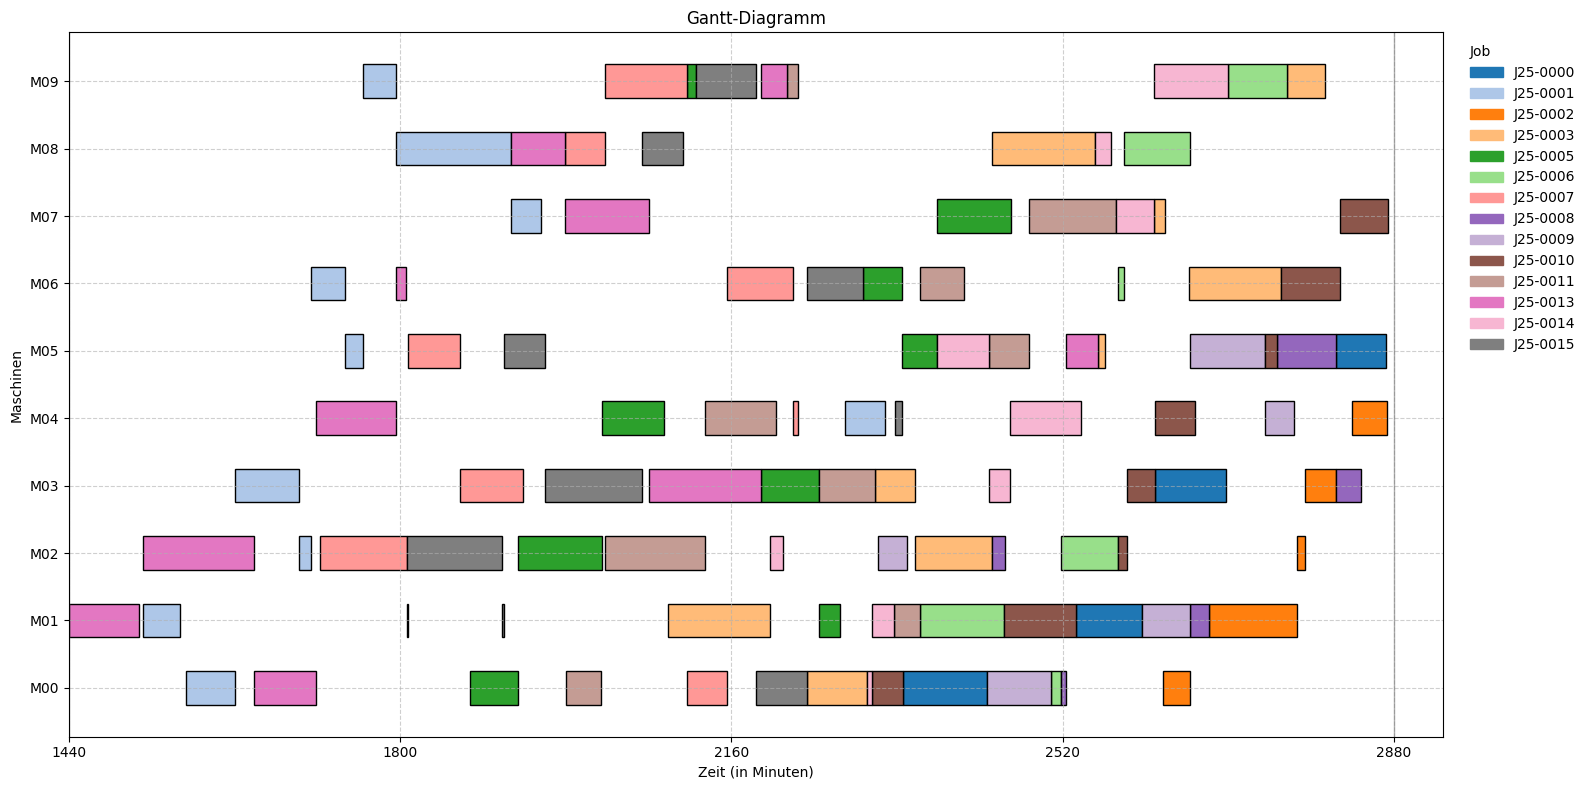

In [13]:
df_execution = simulation.get_finished_operations_df()
gantt.get_plot(df_execution, perspective="Machine")

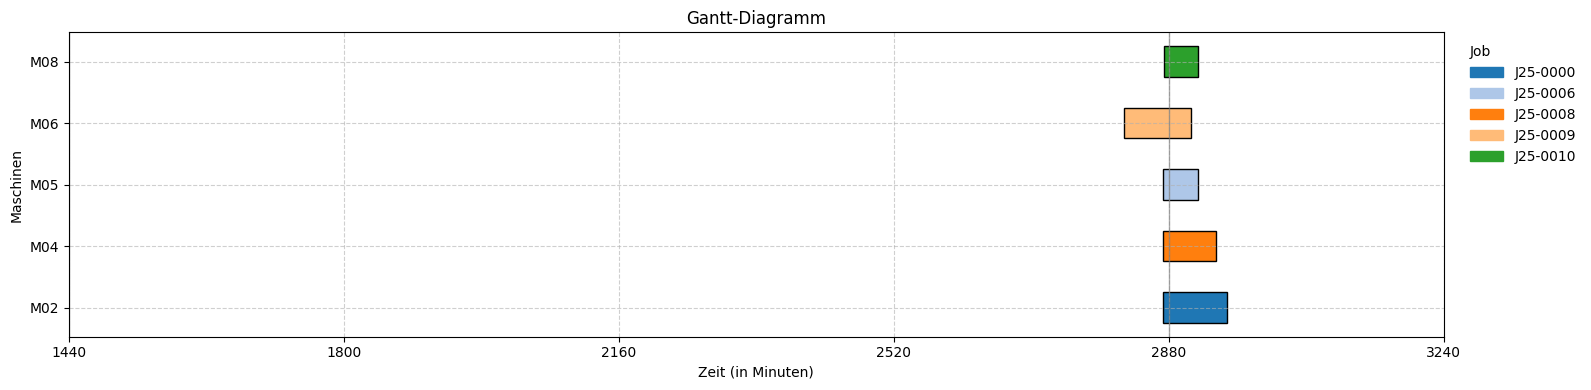

In [14]:
df_active = simulation.get_active_operations_df()
if df_active is not None:
    gantt.get_plot(df_active, perspective="Machine", duration_column="Planned Duration")

In [15]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,5,M09,2901,11,2912
1,J25-0000,8,79,1440,3660,6,M06,2957,40,2997
2,J25-0000,8,79,1440,3660,7,M07,3030,89,3119
3,J25-0000,8,79,1440,3660,8,M04,3119,26,3145
4,J25-0000,8,79,1440,3660,9,M08,3586,74,3660
5,J25-0002,0,198,1440,3744,5,M05,2884,11,2895
...,...,...,...,...,...,...,...,...,...,...
42,J25-0012,2,1103,1440,4385,6,M07,3539,12,3551
43,J25-0012,2,1103,1440,4385,7,M06,3551,89,3640
44,J25-0012,2,1103,1440,4385,8,M09,3640,45,3685


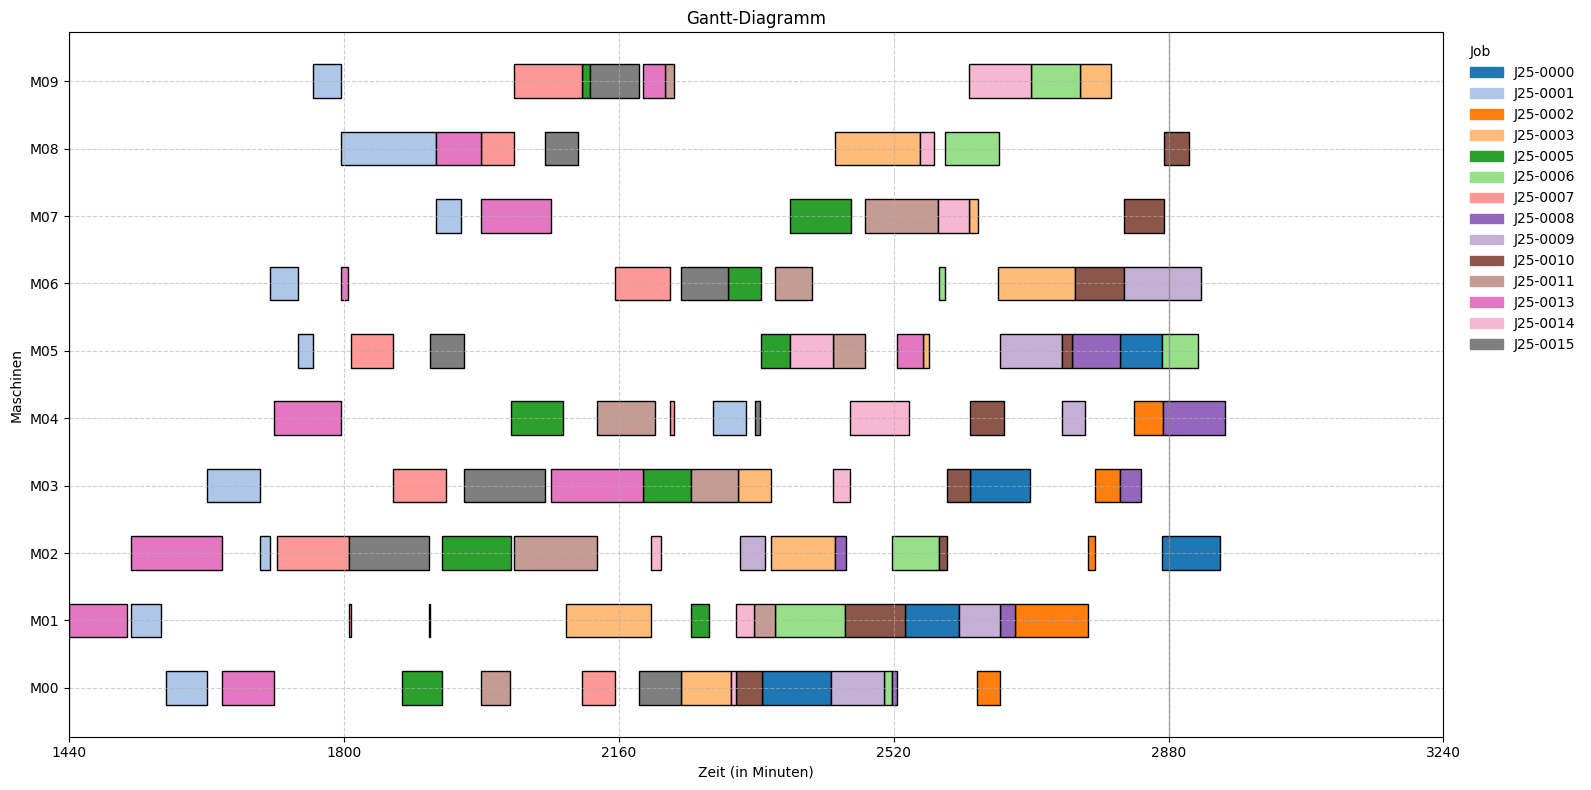

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [16]:
columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns]], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)

## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [17]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [18]:
# "neue" und unerledigte Jobs
df_jobs_times_current = get_current_jobs(df_jobs_times, df_not_started, ready_time=day_start)
df_jobs_times_current

,Job,Routing_ID,Arrival,Ready Time,End,Job Processing Time,Deadline
0,J25-0000,8,79,1440,2704.0,597,3660
2,J25-0002,0,198,1440,2925.0,395,3744
3,J25-0003,2,243,1440,2801.0,568,3379
4,J25-0004,3,287,1440,2697.0,655,4856
5,J25-0005,1,498,1440,2630.0,510,3106
6,J25-0006,9,790,1440,2905.0,540,3539
...,...,...,...,...,...,...,...
32,J25-0032,6,2654,2880,4856.0,416,3881
33,J25-0033,2,2660,2880,5305.0,568,6738
34,J25-0034,8,2715,2880,5271.0,597,6387


In [19]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_times_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
25,J25-0002,0,5,M05,11
...,...,...,...,...,...
374,J25-0037,7,4,M04,32
375,J25-0037,7,5,M06,88
376,J25-0037,7,6,M08,19


### Scheduling


Solver-Status         : OPTIMAL
Objective Value       : 2240.00
Best Objective Bound  : 2196.00
Laufzeit              : 0.88 Sekunden
Deviation terms       : 48


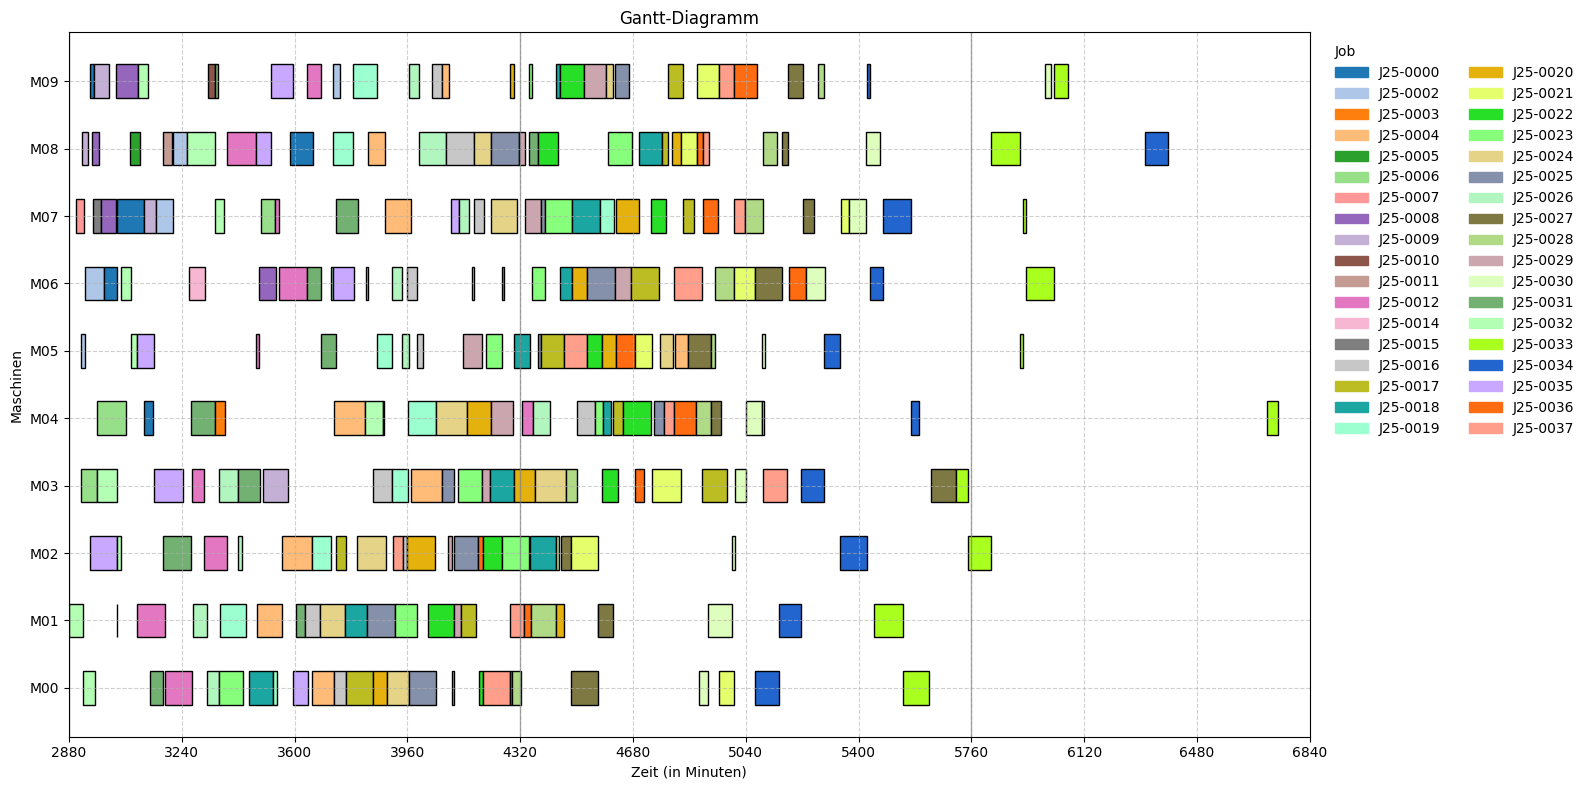

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



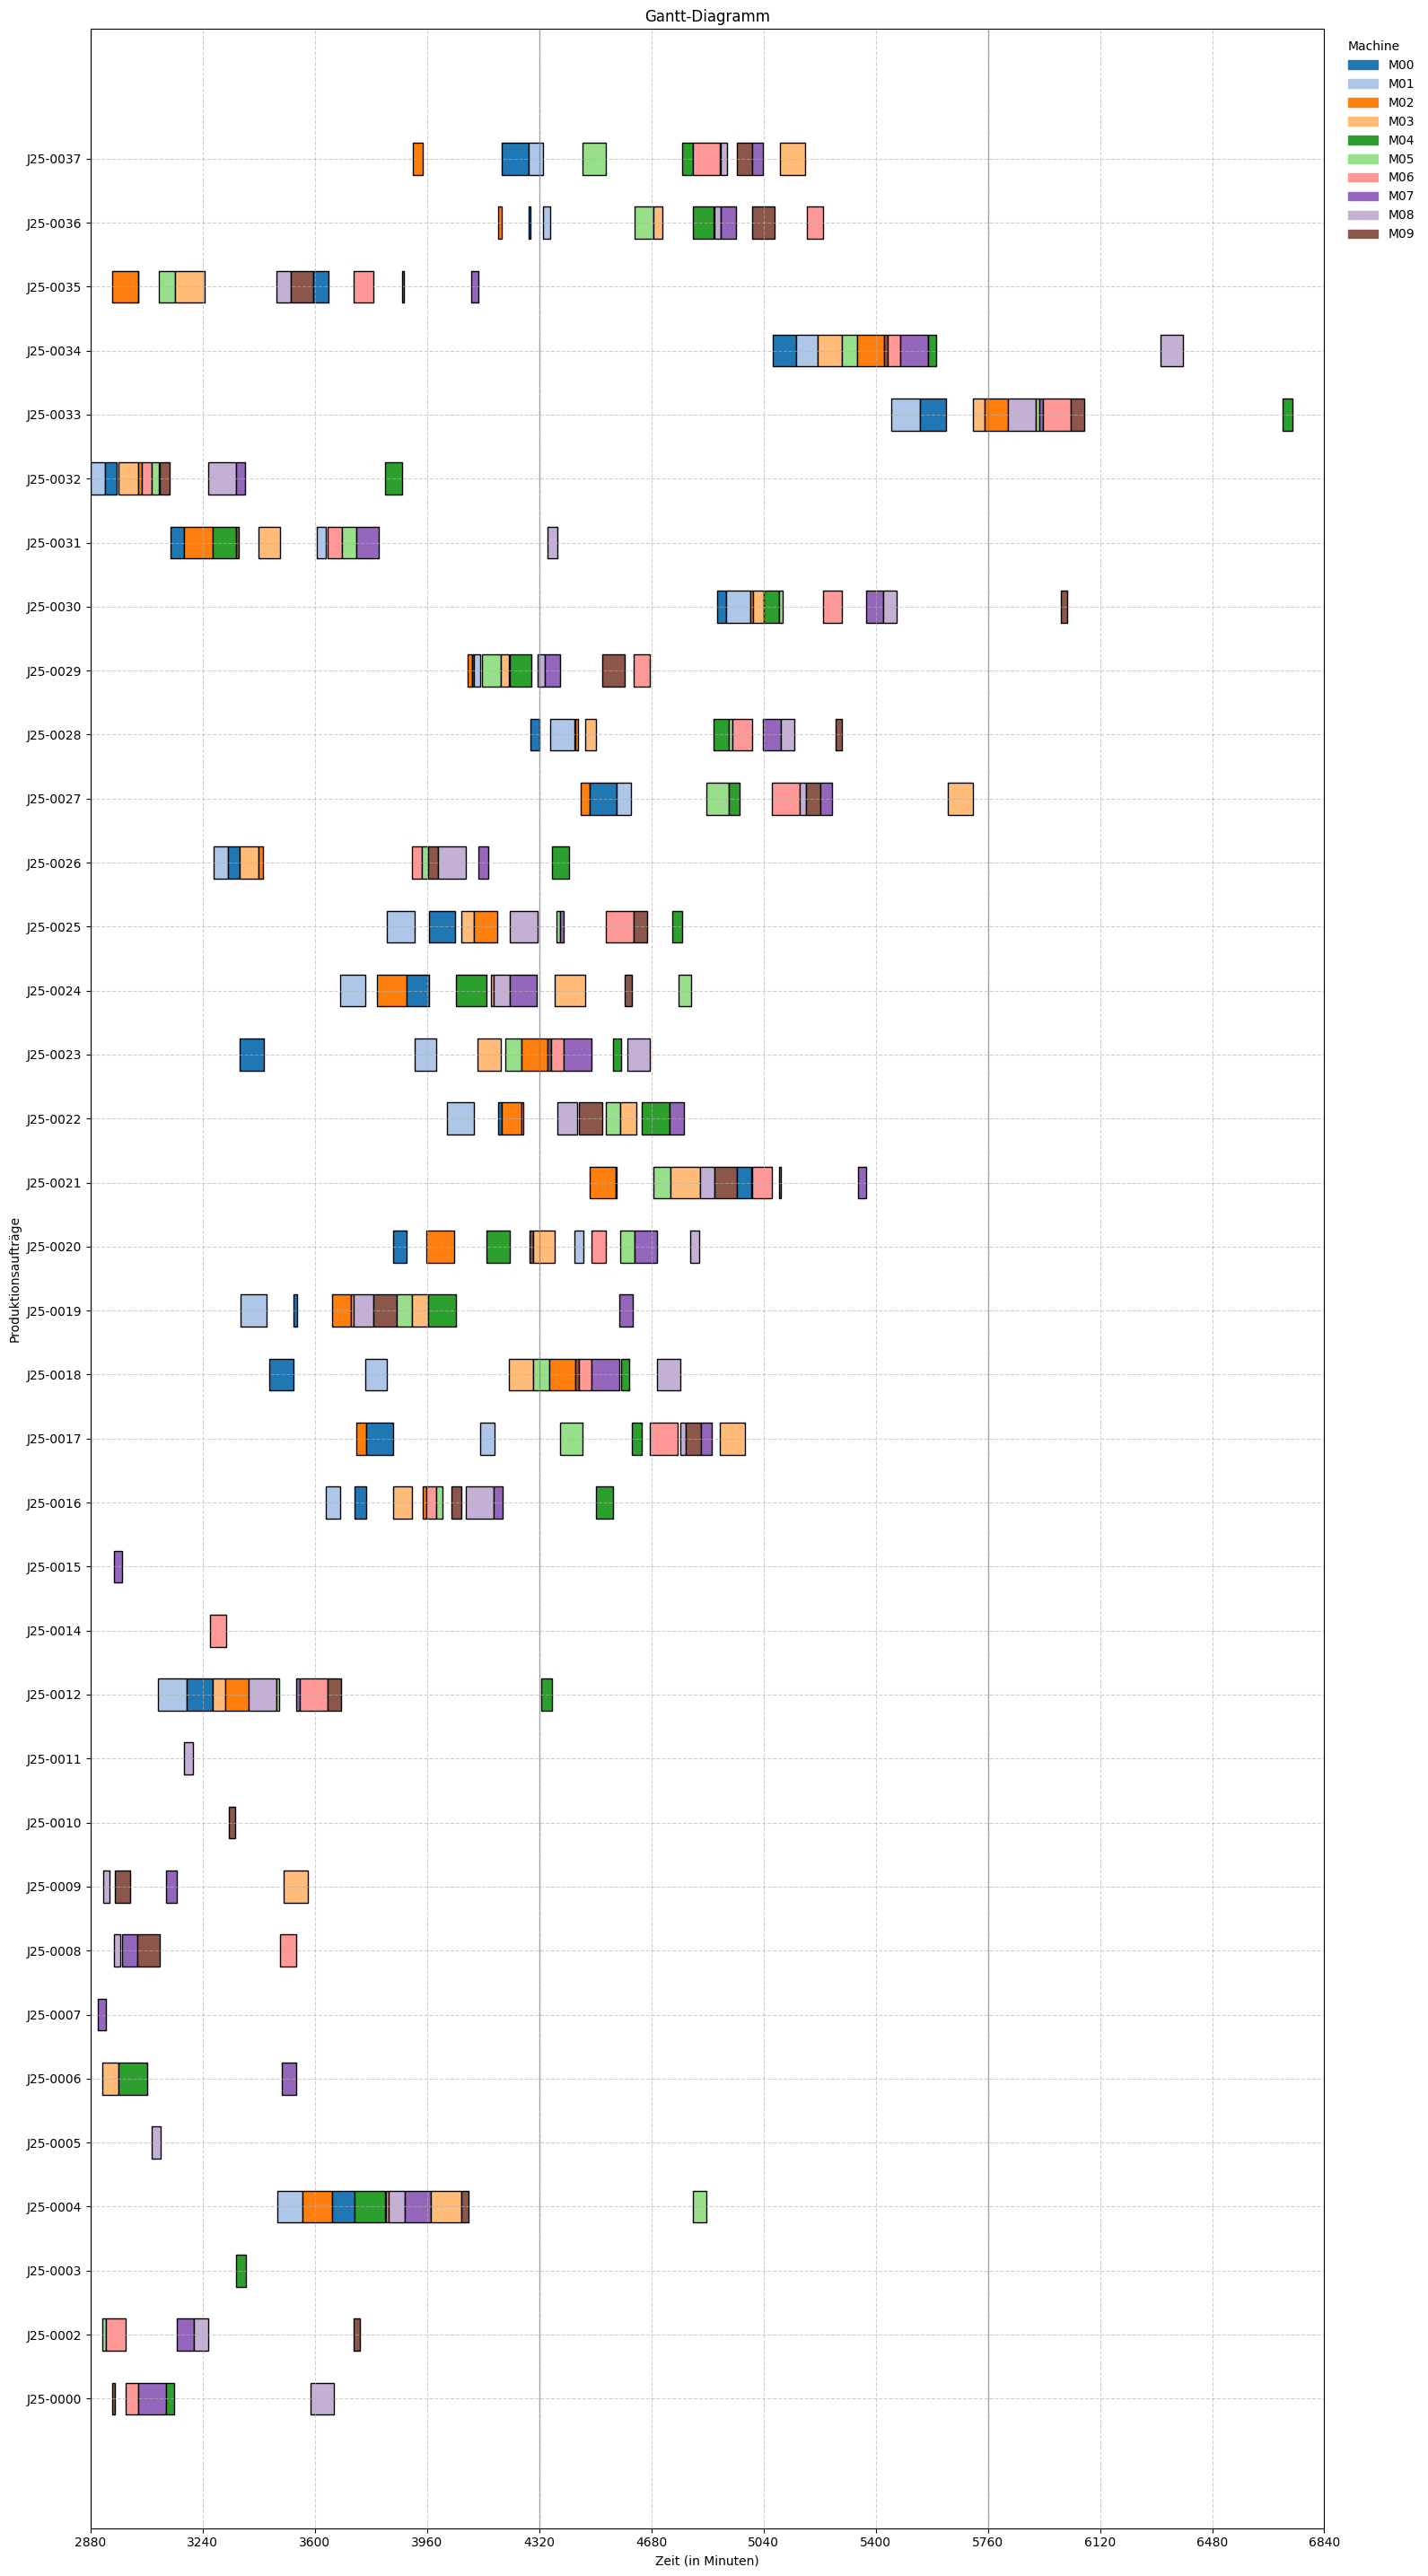

In [20]:
df_schedule_advanced = solver.solve_jssp_lateness_with_start_deviation(
    df_jssp=df_jssp_current,
    df_times=df_jobs_times_current,
    df_original_plan=df_schedule,
    df_active=df_active,
    w_t=30, w_e=5, w_first=1,
    main_pct=0.40,               # 40 % "Lateness mit maximierter Startzeit"; 60 % Abweichungen
    latest_start_buffer=720,
    schedule_start= day_start,
    sort_ascending= None,
    msg=True, timeLimit=max_time, gapRel=0.02
)

gantt.get_plot(df_schedule_advanced, perspective="Machine")
check.all_in_one(df_schedule_advanced)

gantt.get_plot(df_schedule_advanced, perspective="Job")

In [21]:
df_last_ops = get_jobs_with_lateness_metrics(df_schedule_advanced)
get_jobs_aggregated(df_last_ops, column="Lateness", min_val=-30, steps=30, max_val=30)

Lateness_Intervall,<-30,-30 - 0,0,0 - 30,>30
count,0,1,35,0,0


In [22]:
df_compare_02 = seq_tester.analyze_machine_sequences(df_schedule, df_schedule_advanced, 1440*day_numb)
df_compare_02

,original_sequence,revised_sequence_raw,revised_sequence,changed,kendall_tau,levenshtein_distance
Machine,,,,,,
M00,"[J25-0012, J25-0004]","[J25-0032, J25-0031, J25-0012, J25-0026, J25-0023, J25-0018, J25-0019, J25-0035, J25-0004, J25-0016, J25-0017, J25-0...","[J25-0012, J25-0004]",False,1.0,0
M01,"[J25-0012, J25-0004]","[J25-0032, J25-0035, J25-0012, J25-0026, J25-0019, J25-0004, J25-0031, J25-0016, J25-0024, J25-0018, J25-0025, J25-0...","[J25-0012, J25-0004]",False,1.0,0
M02,"[J25-0012, J25-0004]","[J25-0035, J25-0032, J25-0031, J25-0012, J25-0026, J25-0004, J25-0019, J25-0017, J25-0024, J25-0037, J25-0016, J25-0...","[J25-0012, J25-0004]",False,1.0,0
M03,"[J25-0012, J25-0009, J25-0004]","[J25-0006, J25-0032, J25-0035, J25-0012, J25-0026, J25-0031, J25-0009, J25-0016, J25-0019, J25-0004, J25-0025, J25-0...","[J25-0012, J25-0009, J25-0004]",False,1.0,0
M04,"[J25-0006, J25-0000, J25-0003, J25-0004, J25-0012]","[J25-0006, J25-0000, J25-0031, J25-0003, J25-0004, J25-0032, J25-0035, J25-0019, J25-0024, J25-0020, J25-0029, J25-0...","[J25-0006, J25-0000, J25-0003, J25-0004, J25-0012]",False,1.0,0
M05,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0032, J25-0035, J25-0012, J25-0031, J25-0019, J25-0026, J25-0016, J25-0029, J25-0023, J25-0018, J25-0...","[J25-0002, J25-0012, J25-0004]",False,1.0,0
M06,"[J25-0002, J25-0000, J25-0014, J25-0008, J25-0012, J25-0004]","[J25-0002, J25-0000, J25-0032, J25-0014, J25-0008, J25-0012, J25-0031, J25-0019, J25-0035, J25-0004, J25-0026, J25-0...","[J25-0002, J25-0000, J25-0014, J25-0008, J25-0012, J25-0004]",False,1.0,0
M07,"[J25-0007, J25-0015, J25-0008, J25-0000, J25-0009, J25-0002, J25-0006, J25-0012, J25-0004]","[J25-0007, J25-0015, J25-0008, J25-0000, J25-0009, J25-0002, J25-0032, J25-0006, J25-0012, J25-0031, J25-0004, J25-0...","[J25-0007, J25-0015, J25-0008, J25-0000, J25-0009, J25-0002, J25-0006, J25-0012, J25-0004]",False,1.0,0
M08,"[J25-0005, J25-0011, J25-0002, J25-0012, J25-0000, J25-0004]","[J25-0009, J25-0008, J25-0005, J25-0011, J25-0002, J25-0032, J25-0012, J25-0035, J25-0000, J25-0019, J25-0004, J25-0...","[J25-0005, J25-0011, J25-0002, J25-0012, J25-0000, J25-0004]",False,1.0,0


### B) Neuplanung


$$
\begin{aligned}
\min\ Z =\; & p \cdot \sum_{j \in J} \Big(
w_t \cdot \max(C_j - D_j,\ 0) \\
&\quad +\ w_e \cdot \max(D_j - C_j,\ 0) \\
&\quad +\ w_{\text{first}} \cdot \max(L_j^{\text{desired}} - S_{j,0},\ 0)
\Big) \\
& +\ (1 - p) \cdot \sum_{m \in M} \sum_{(o_1,\ o_2) \in \text{Seq}_m^{\text{orig}}} \delta_{o_1,o_2}
\end{aligned}
$$

mit:

* $\delta_{o_1,o_2} = 1$, wenn im neuen Plan $o_1$ **nach** $o_2$ startet (Reihenfolge vertauscht),
* sonst $\delta_{o_1,o_2} = 0$.



Solver-Status         : OPTIMAL
Objective Value       : 250.00
Best Objective Bound  : 250.00
Laufzeit              : 0.25 Sekunden
Deviation-Paare       : 122


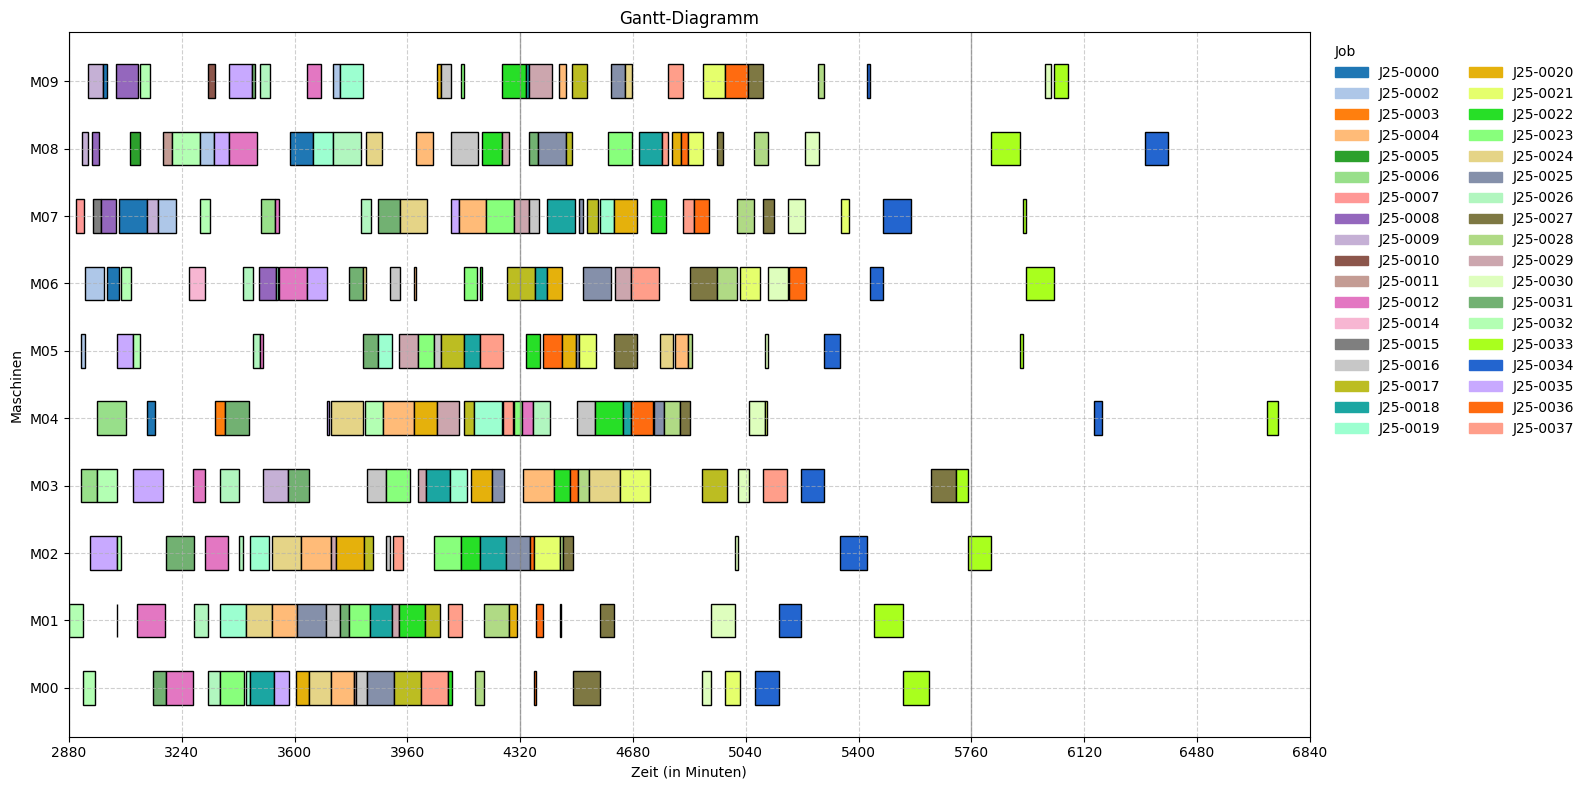

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



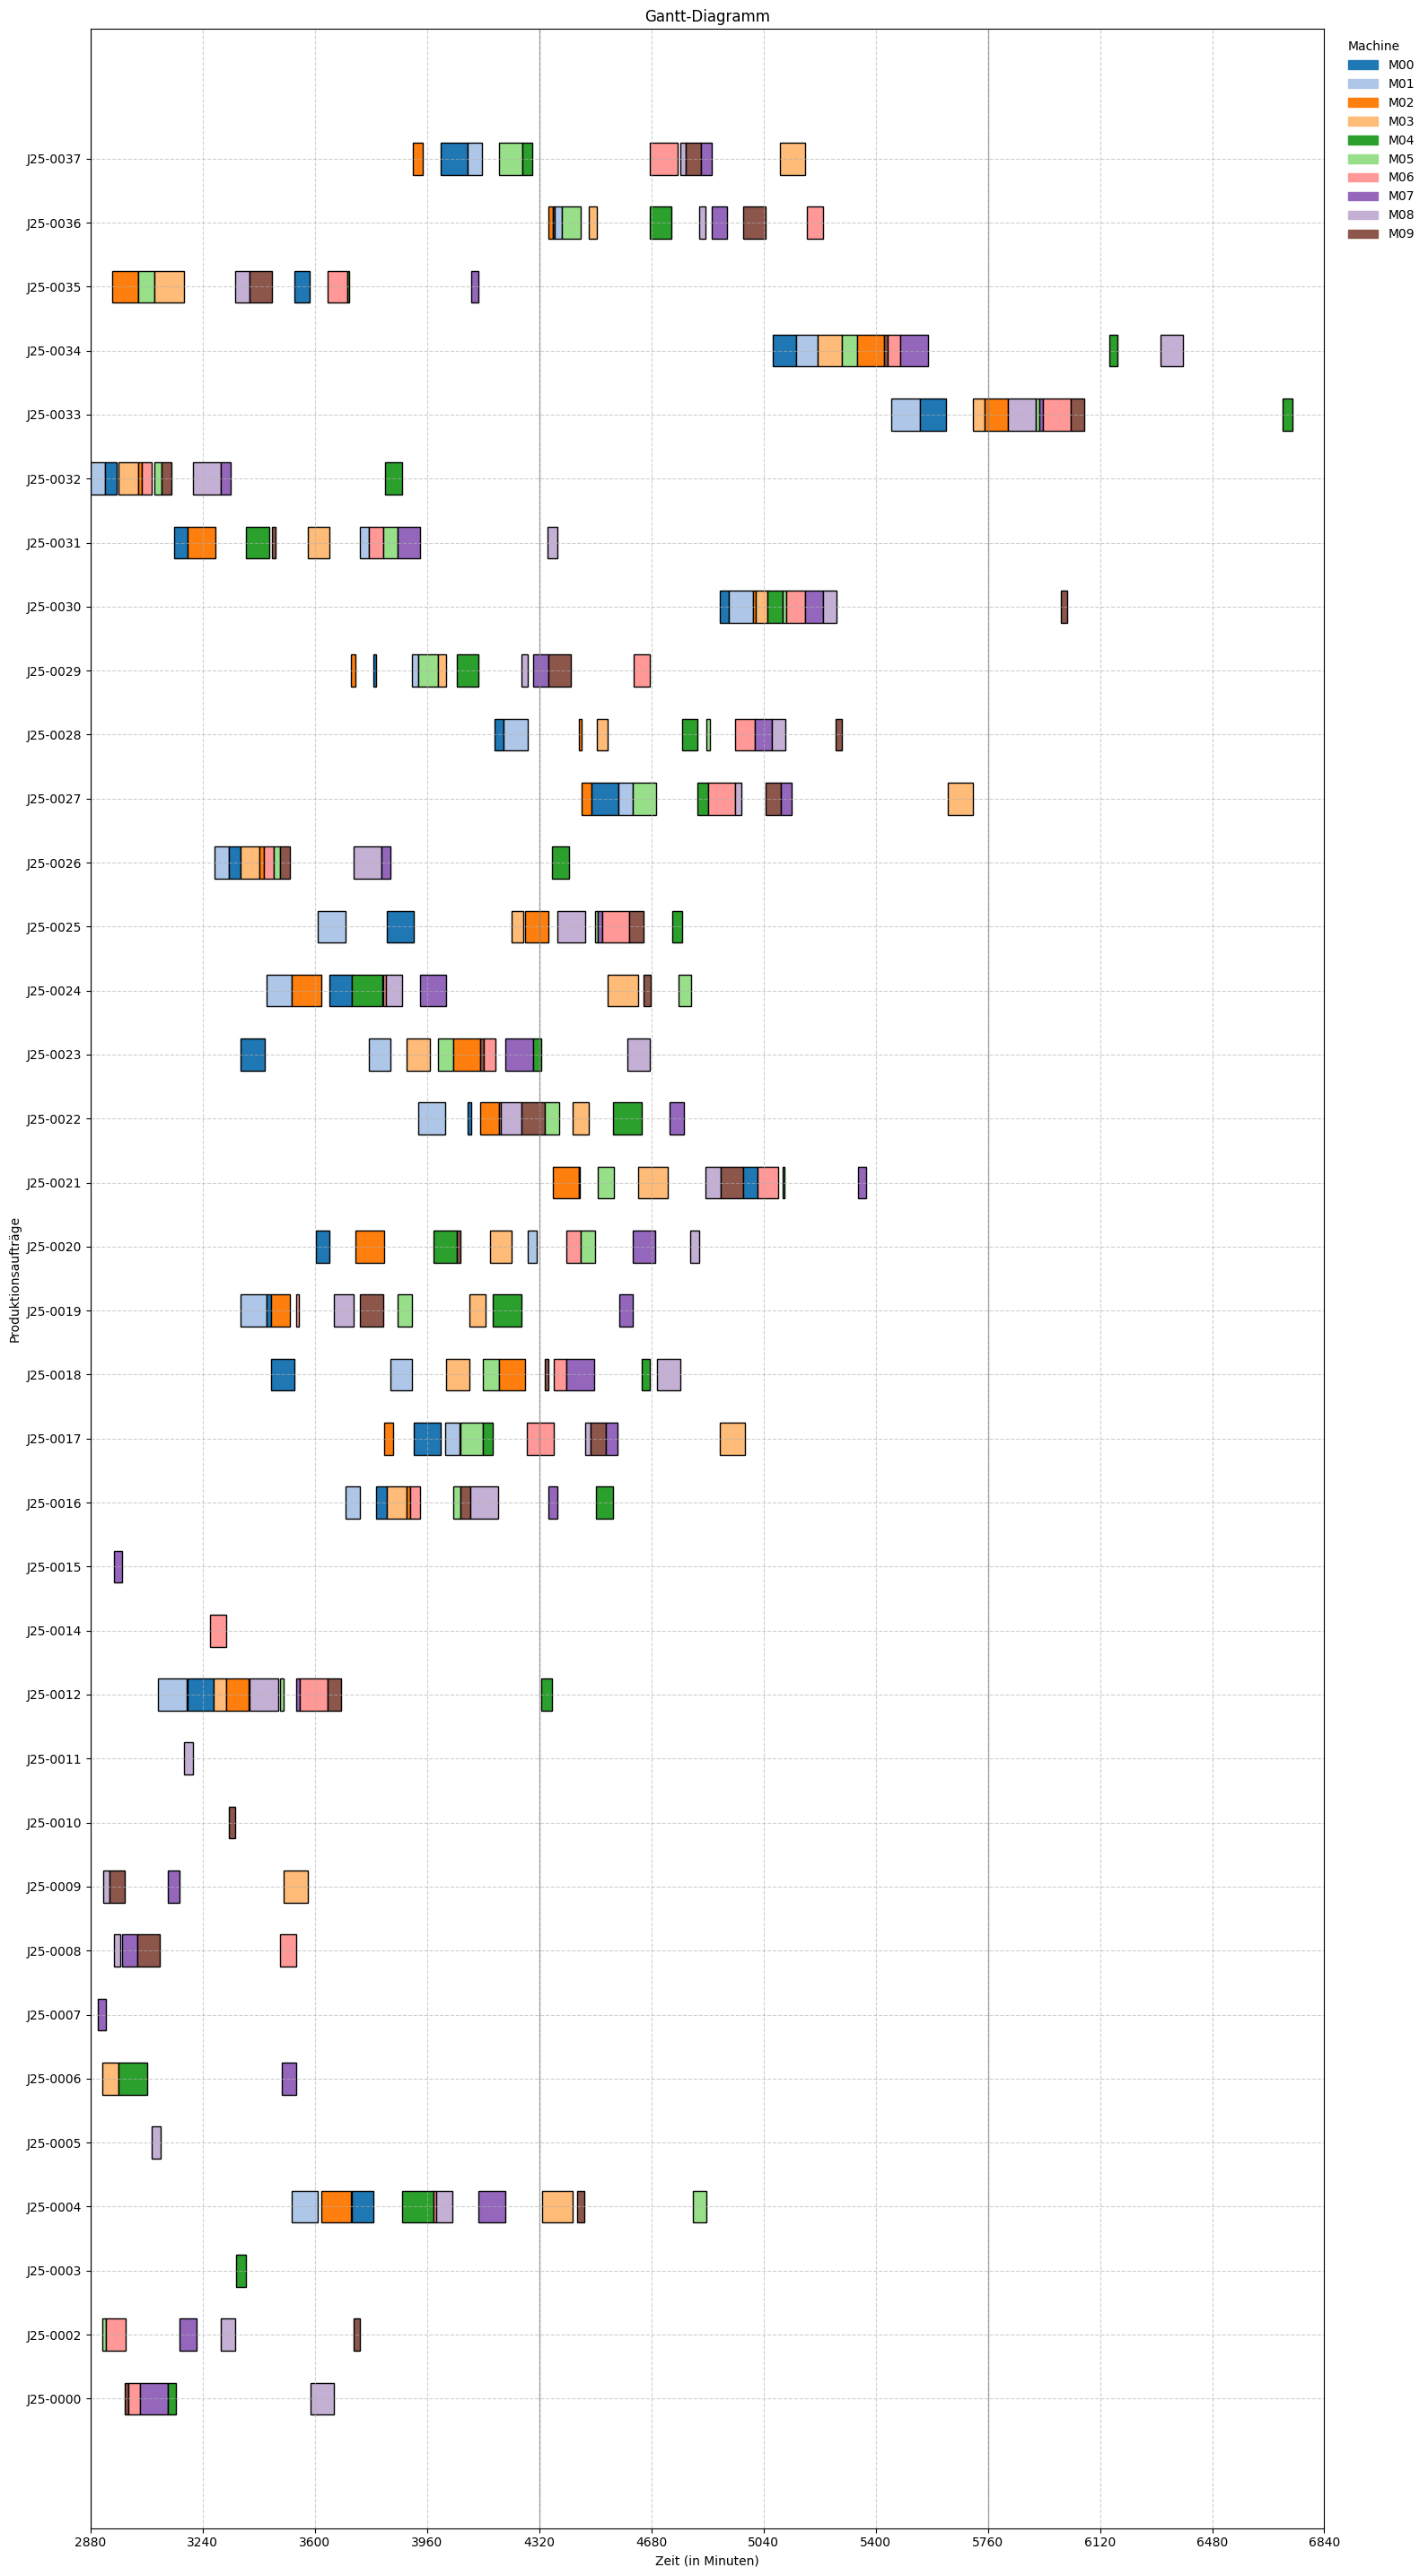

In [23]:
df_schedule_advanced = solver.solve_jssp_lateness_with_order_deviation(
    df_jssp=df_jssp_current,
    df_times=df_jobs_times_current,
    df_original_plan=df_schedule,
    df_active=df_active,
    w_t=30, w_e=5, w_first=1,
    main_pct=0.40,               # 40 % "Lateness mit maximierter Startzeit"; 60 % Abweichungen
    latest_start_buffer=720,
    schedule_start= day_start,
    sort_ascending= None,
    msg=True, timeLimit=max_time, gapRel=0.02
)

gantt.get_plot(df_schedule_advanced, perspective="Machine")
check.all_in_one(df_schedule_advanced)

gantt.get_plot(df_schedule_advanced, perspective="Job")

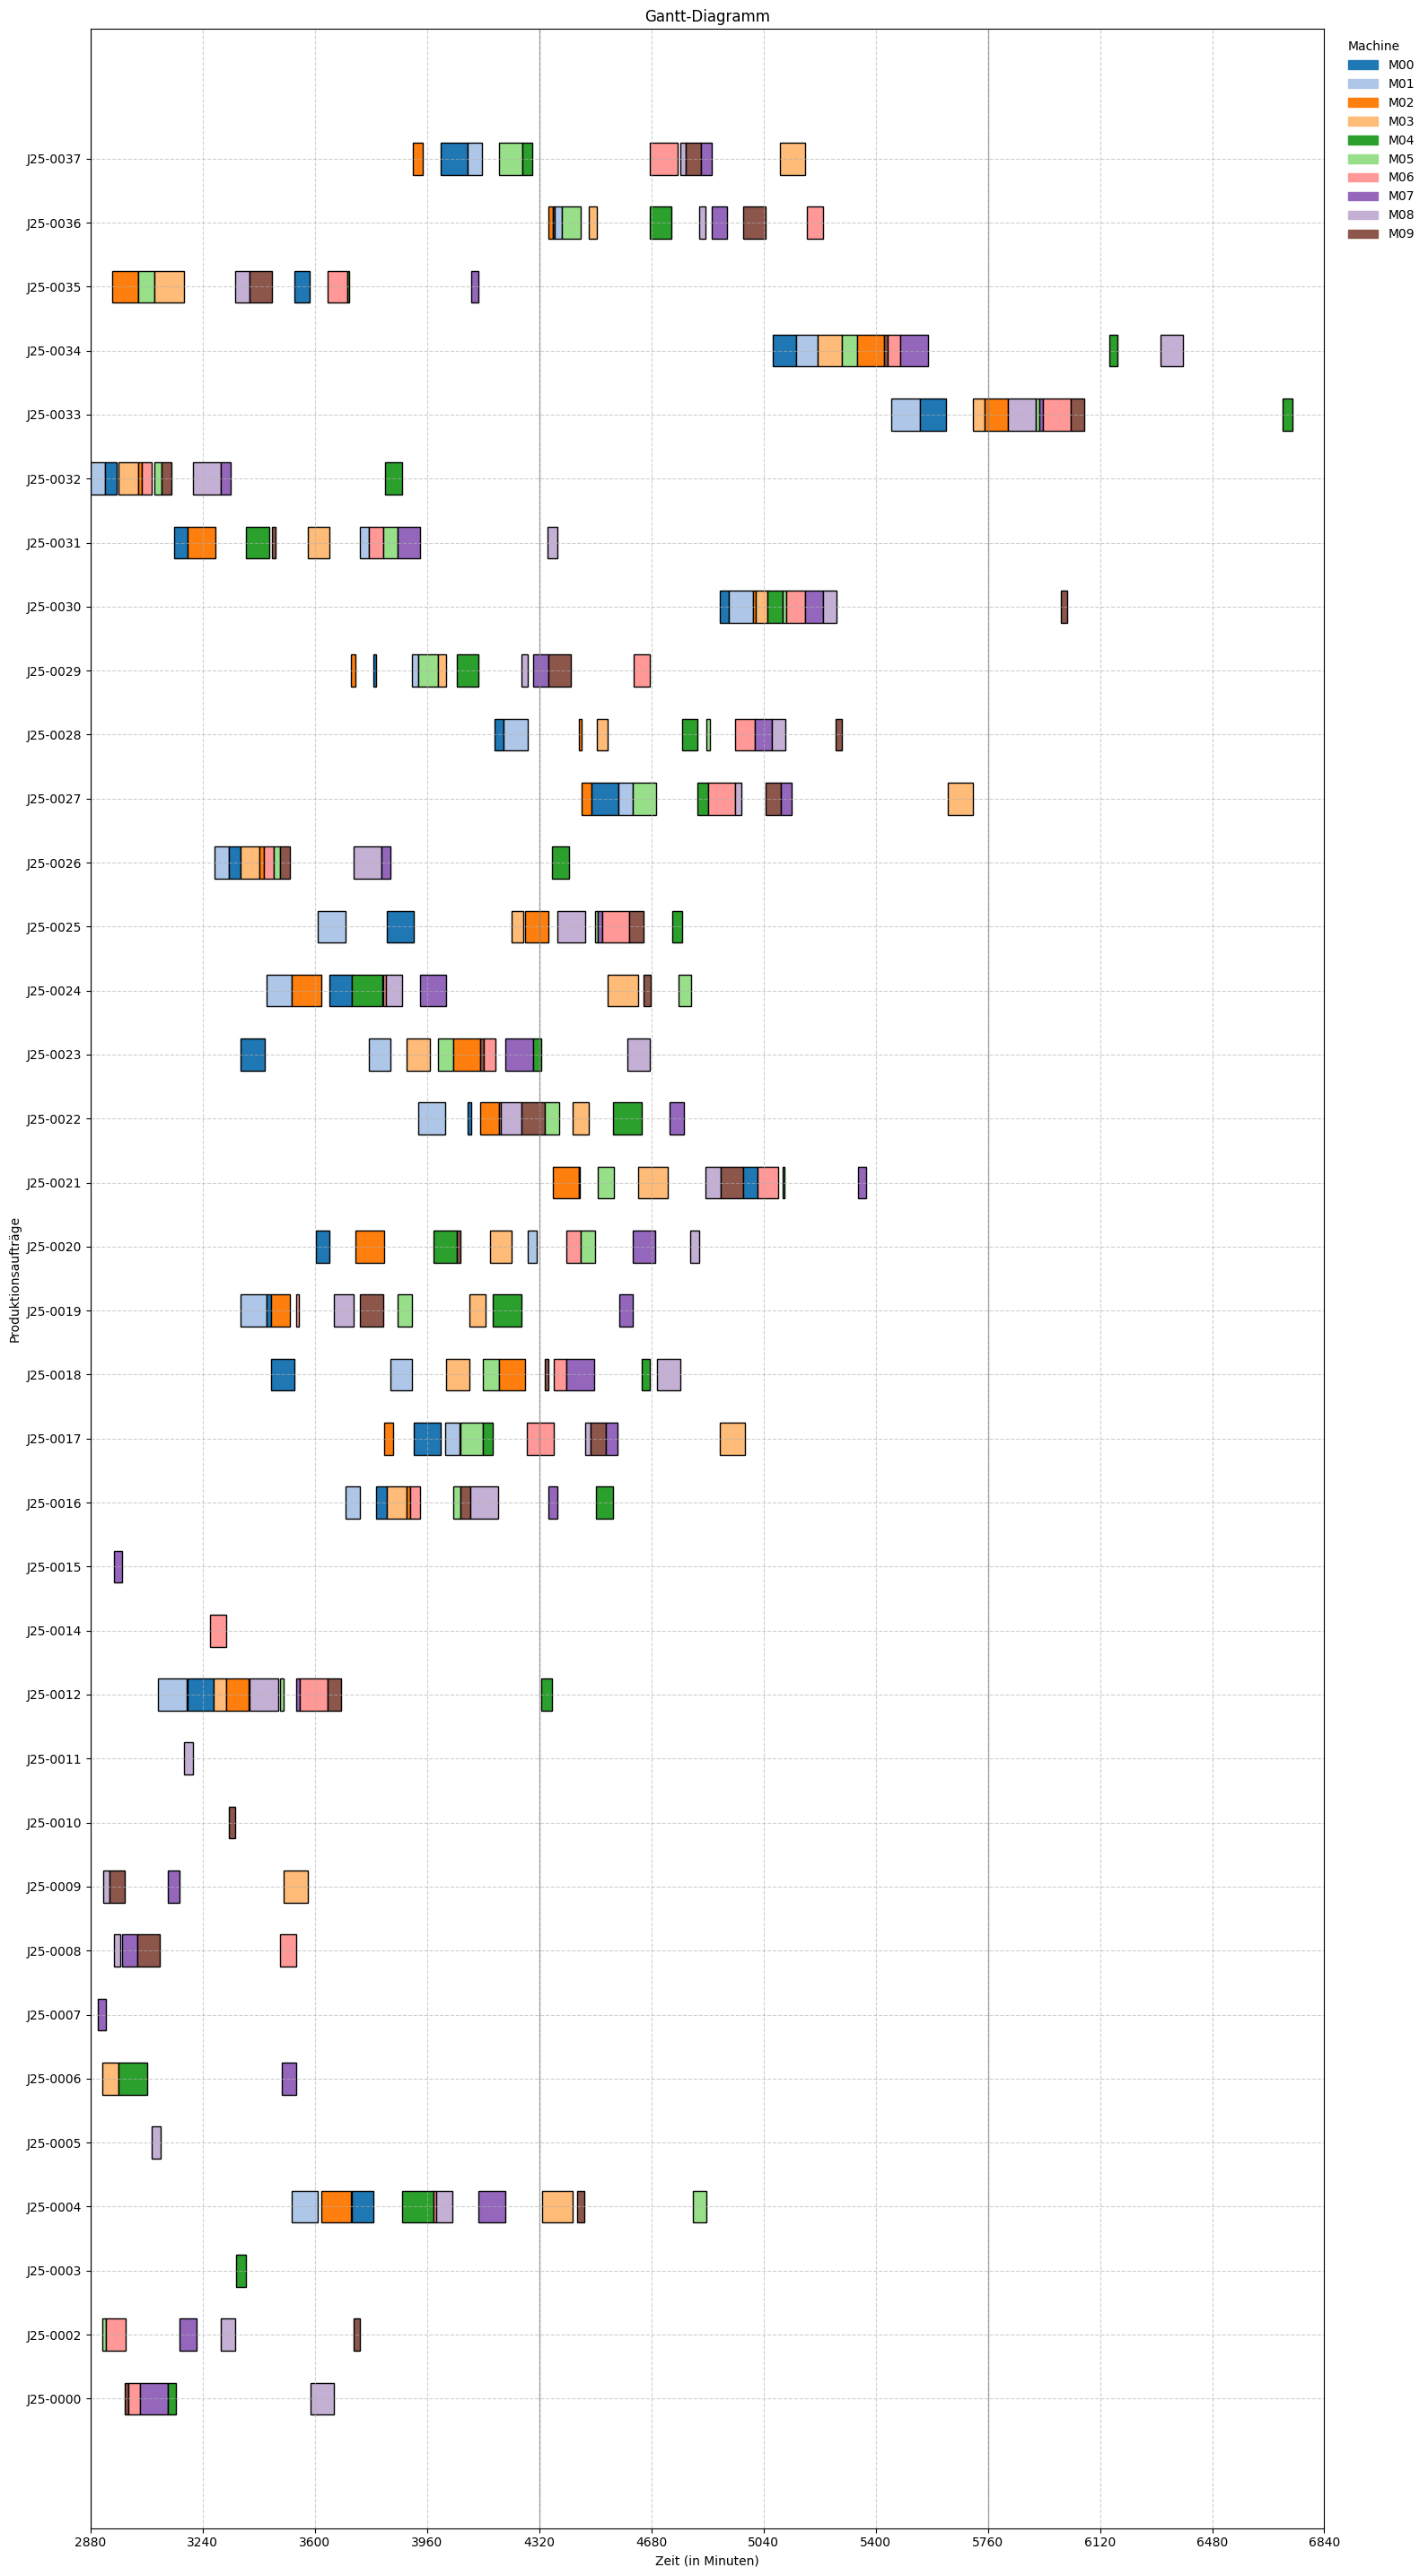

Lateness_Intervall,<-30,-30 - 0,0,0 - 30,>30
count,0,1,35,0,0


In [24]:
gantt.get_plot(df_schedule_advanced, perspective="Job")
df_last_ops = get_jobs_with_lateness_metrics(df_schedule_advanced)
get_jobs_aggregated(df_last_ops, column="Lateness", min_val=-30, steps=30, max_val=30)

In [25]:
df_compare_02 = seq_tester.analyze_machine_sequences(df_schedule, df_schedule_advanced, 1440*day_numb)
df_compare_02

,original_sequence,revised_sequence_raw,revised_sequence,changed,kendall_tau,levenshtein_distance
Machine,,,,,,
M00,"[J25-0012, J25-0004]","[J25-0032, J25-0031, J25-0012, J25-0026, J25-0023, J25-0019, J25-0018, J25-0035, J25-0020, J25-0024, J25-0004, J25-0...","[J25-0012, J25-0004]",False,1.0,0
M01,"[J25-0012, J25-0004]","[J25-0032, J25-0035, J25-0012, J25-0026, J25-0019, J25-0024, J25-0004, J25-0025, J25-0016, J25-0031, J25-0023, J25-0...","[J25-0012, J25-0004]",False,1.0,0
M02,"[J25-0012, J25-0004]","[J25-0035, J25-0032, J25-0031, J25-0012, J25-0026, J25-0019, J25-0024, J25-0004, J25-0029, J25-0020, J25-0017, J25-0...","[J25-0012, J25-0004]",False,1.0,0
M03,"[J25-0012, J25-0009, J25-0004]","[J25-0006, J25-0032, J25-0035, J25-0012, J25-0026, J25-0009, J25-0031, J25-0016, J25-0023, J25-0029, J25-0018, J25-0...","[J25-0012, J25-0009, J25-0004]",False,1.0,0
M04,"[J25-0006, J25-0000, J25-0003, J25-0004, J25-0012]","[J25-0006, J25-0000, J25-0003, J25-0031, J25-0035, J25-0024, J25-0032, J25-0004, J25-0020, J25-0029, J25-0017, J25-0...","[J25-0006, J25-0000, J25-0003, J25-0004, J25-0012]",False,1.0,0
M05,"[J25-0002, J25-0012, J25-0004]","[J25-0002, J25-0035, J25-0032, J25-0026, J25-0012, J25-0031, J25-0019, J25-0029, J25-0023, J25-0016, J25-0017, J25-0...","[J25-0002, J25-0012, J25-0004]",False,1.0,0
M06,"[J25-0002, J25-0000, J25-0014, J25-0008, J25-0012, J25-0004]","[J25-0002, J25-0000, J25-0032, J25-0014, J25-0026, J25-0008, J25-0019, J25-0012, J25-0035, J25-0031, J25-0024, J25-0...","[J25-0002, J25-0000, J25-0014, J25-0008, J25-0012, J25-0004]",False,1.0,0
M07,"[J25-0007, J25-0015, J25-0008, J25-0000, J25-0009, J25-0002, J25-0006, J25-0012, J25-0004]","[J25-0007, J25-0015, J25-0008, J25-0000, J25-0009, J25-0002, J25-0032, J25-0006, J25-0012, J25-0026, J25-0031, J25-0...","[J25-0007, J25-0015, J25-0008, J25-0000, J25-0009, J25-0002, J25-0006, J25-0012, J25-0004]",False,1.0,0
M08,"[J25-0005, J25-0011, J25-0002, J25-0012, J25-0000, J25-0004]","[J25-0009, J25-0008, J25-0005, J25-0011, J25-0032, J25-0002, J25-0035, J25-0012, J25-0000, J25-0019, J25-0026, J25-0...","[J25-0005, J25-0011, J25-0002, J25-0012, J25-0000, J25-0004]",False,1.0,0


### Simulation

In [26]:
simulation.run(dframe_schedule_plan = df_schedule_advanced, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0009, Operation 5 resumed on M06 (with 42 minutes left)
[Day 2 00:00:00] Job J25-0006, Operation 6 resumed on M05 (with 39 minutes left)
[Day 2 00:00:00] Job J25-0000, Operation 4 resumed on M02 (with 68 minutes left)
[Day 2 00:00:00] Job J25-0008, Operation 5 resumed on M04 (with 74 minutes left)
[Day 2 00:00:00] Job J25-0010, Operation 8 resumed on M08 (with 27 minutes left)
[Day 2 00:00:00] Job J25-0032 started on M01
[Day 2 00:24:00] Job J25-0007 started on M07
[Day 2 00:27:00] Job J25-0010 finished on M08 (after 27 minutes)
[Day 2 00:39:00] Job J25-0006 finished on M05 (after 39 minutes)
[Day 2 00:39:00] Job J25-0002 started on M05
[Day 2 00:39:00] Job J25-0006 started on M03
[Day 2 00:42:00] Job J25-0009 finished on M06 (after 42 minutes)
[Day 2 00:42:00] Job J25-0009 started on M08
[Day 2 00:44:00] Job J25-0032 finished on M01 (after 44 minutes)
[Day 2 00:46:00] Job J25-0032 started on M00
[Day 2 00:50:00] Job J25-0007 finished on M07 (after 26 minutes)


In [27]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Routing_ID,Arrival,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,4,M02,2872.0,76.0,2948.0
1,J25-0000,8,79,5,M09,2990.0,11.0,3001.0
2,J25-0000,8,79,6,M06,3004.0,36.0,3040.0
3,J25-0000,8,79,7,M07,3040.0,83.0,3123.0
4,J25-0000,8,79,8,M04,3129.0,36.0,3165.0
5,J25-0000,8,79,9,M08,3586.0,61.0,3647.0
...,...,...,...,...,...,...,...,...
148,J25-0035,5,2726,8,M04,3836.0,6.0,3842.0
149,J25-0035,5,2726,9,M07,4101.0,33.0,4134.0
150,J25-0037,7,2801,0,M02,3914.0,28.0,3942.0


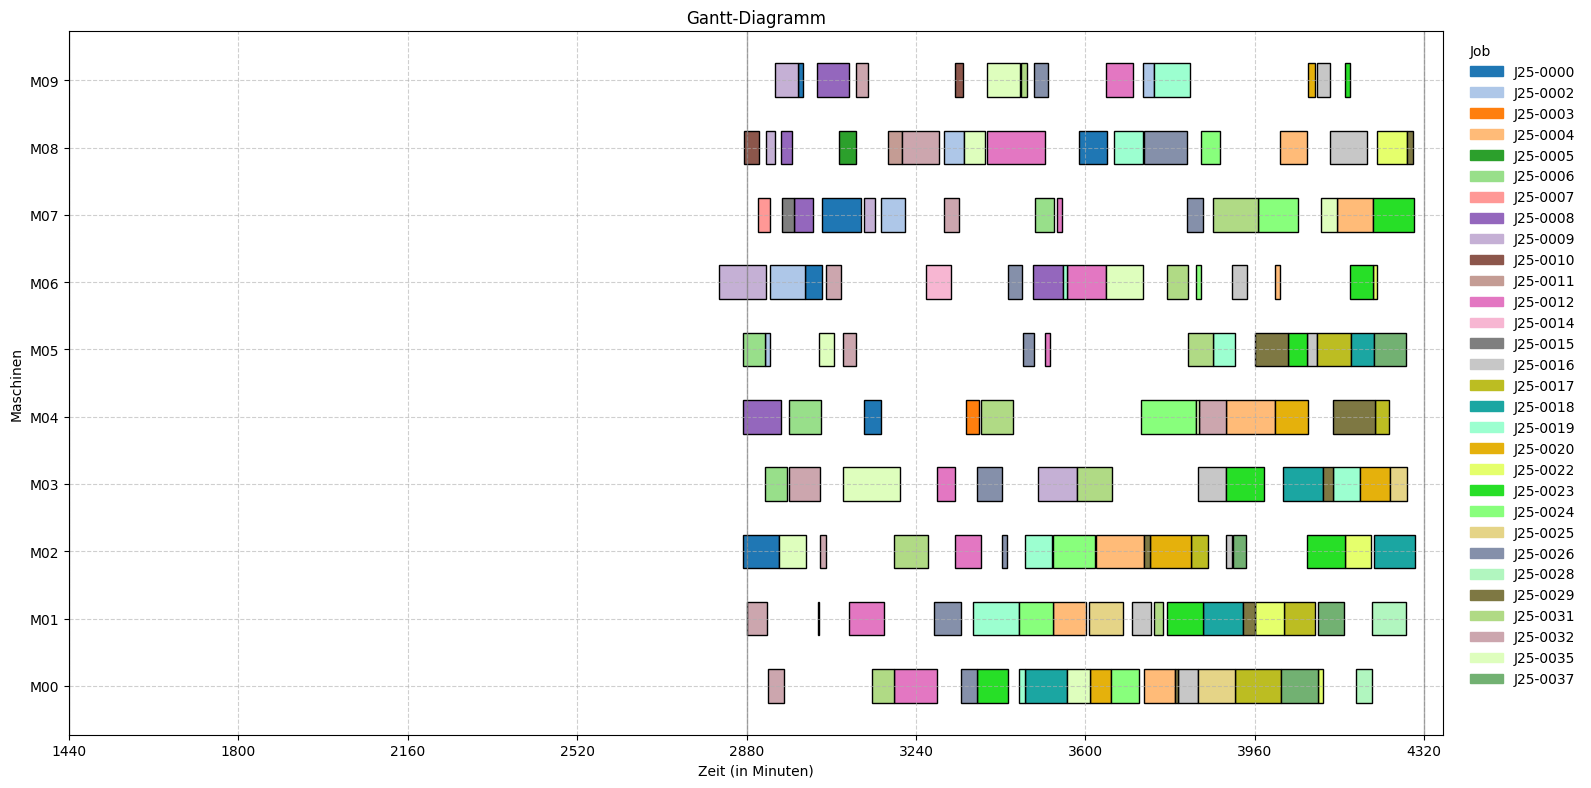

In [28]:
gantt.get_plot(df_execution2, perspective="Machine")

In [29]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Routing_ID,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,7,J25-0017,5,M06,1864,4279.0,88,78.0,4367.0,4357.0
1,9,J25-0019,8,M04,1925,4246.0,90,92.0,4336.0,4338.0
2,1,J25-0020,5,M01,1935,4283.0,28,37.0,4311.0,4320.0
3,9,J25-0022,5,M09,2001,4284.0,76,76.0,4360.0,4360.0
4,2,J25-0025,3,M02,2126,4301.0,74,94.0,4375.0,4395.0
5,4,J25-0029,7,M07,2301,4300.0,49,43.0,4349.0,4343.0


In [30]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Arrival,Ready Time,Deadline,Operation,Machine,Start,Processing Time,End
0,J25-0000,8,79,1440,3660,0,M00,2343,76,2419
1,J25-0000,8,79,1440,3660,1,M01,2490,69,2559
2,J25-0000,8,79,1440,3660,2,M03,2559,76,2635
3,J25-0000,8,79,1440,3660,3,M05,2740,51,2791
4,J25-0001,6,129,1440,2338,0,M01,1521,46,1567
5,J25-0001,6,129,1440,2338,1,M00,1567,37,1604
...,...,...,...,...,...,...,...,...,...,...
105,J25-0015,5,1436,1440,2981,3,M03,1946,95,2041
106,J25-0015,5,1436,1440,2981,4,M08,2041,48,2089
107,J25-0015,5,1436,1440,2981,5,M09,2095,72,2167


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

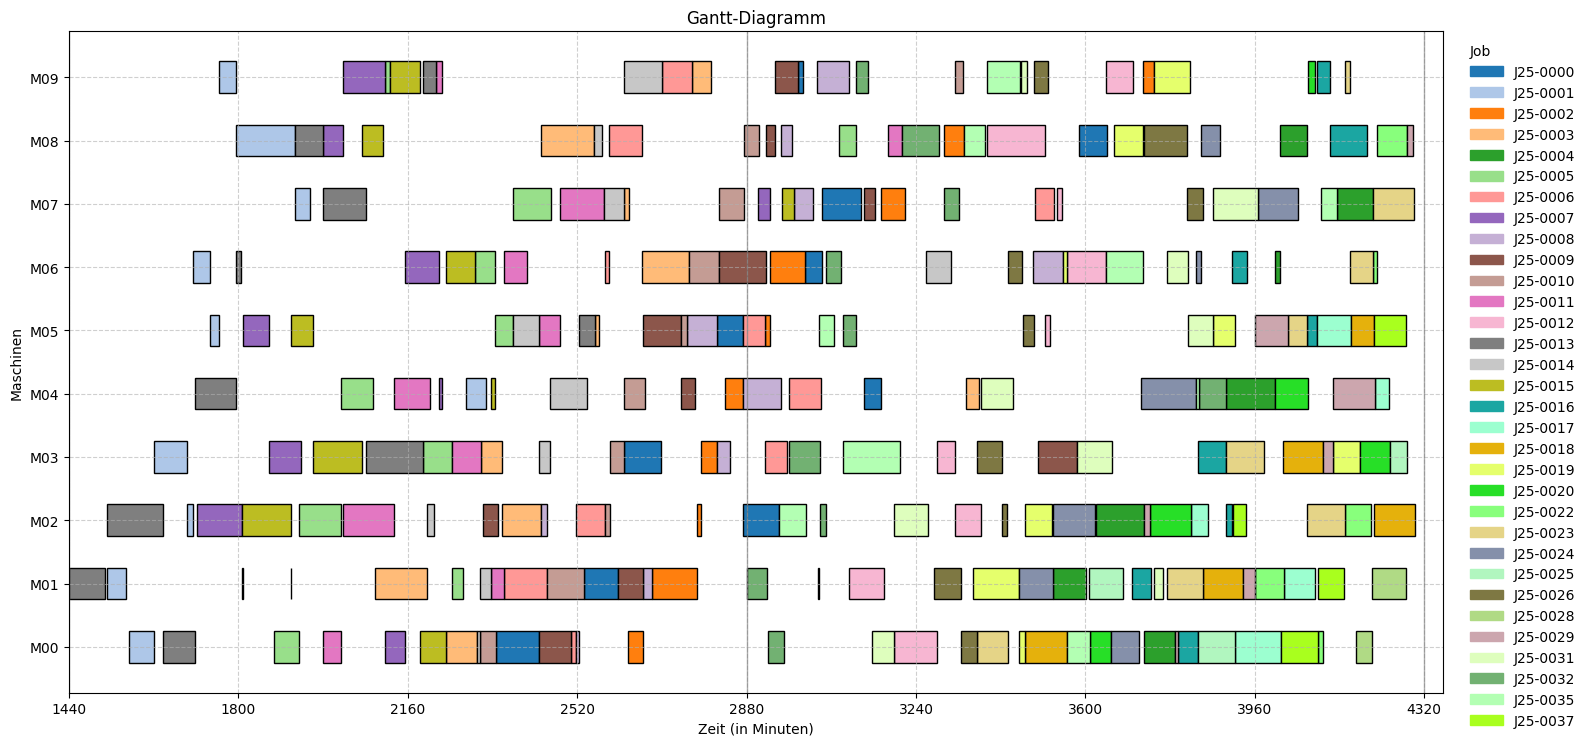

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [31]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
gantt.get_plot(df_combined, perspective="Machine")
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)